# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Для начала установим и импортируем все необходимые библиотеки

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from matplotlib import pyplot as plt 
import phik
import seaborn as sns
#import shap
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind
from scipy.stats import t



# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer



# загружаем функцию для работы с метриками
from sklearn.metrics import r2_score,confusion_matrix,mean_squared_error



# импортируем класс RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# загружаем нужные модели
from sklearn.linear_model import LinearRegression

import os

#Фиксируем константу для рандомизации
RANDOM_STATE = 42

Данные с константами

In [3]:
ALL_WELL = 500  # разведка скважин (кол-во)
NUM = 200  # разработка скважин (кол-во)
STORE = 10**10 # бюджет на разработку скважин в регионе
PRICE = 450000  # прибыли с единиы целевого признака

### Предобработка данных

In [4]:
pth1 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'
pth3 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'
# if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
#     data1 = pd.read_csv(pth1)
#     data2 = pd.read_csv(pth2)
#     data3 = pd.read_csv(pth3)
# else:
#     print('Something is wrong')
# os.path.exists(pth2)

In [5]:
try:
    data1 = pd.read_csv(pth1)
    data2 = pd.read_csv(pth2)
    data3 = pd.read_csv(pth3)
except:
    print('Something is wrong')

In [6]:
data1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data2.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные загружены, пропусков в данных не обнаружено, стоит проверить дубликаты по id. Количество записей в каждом файле - 10 тыс штук(скважин)

In [12]:
data1.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [13]:
data2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [14]:
data3.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Во всех данных есть дубликаты по id, возможно проблема в регистре, но так как записей меньше (или равно) 10 штук из 100 тыс их лучше убрать. Также есть проблема во втором сете, там всего 12 уникальных значений по целевому признаку (объём запасов в скважине). Возможно, это приведёт к большим проблемам в процессе обучения модели

Устраним дубликаты по id  из каждого набора данных

In [15]:
for df in [data1,data2,data3]:
    df.drop_duplicates(subset='id',inplace=True)
data1.shape

(99990, 5)

Дубликаты удалены. в целом предобработка данных завершена. Можно переходить к исследовательскому анализу данных и разбираться в данных здесь

In [16]:
for df in [data1,data2,data3]:
    print(df.duplicated().sum())

0
0
0


### Исследовательский анализ данных

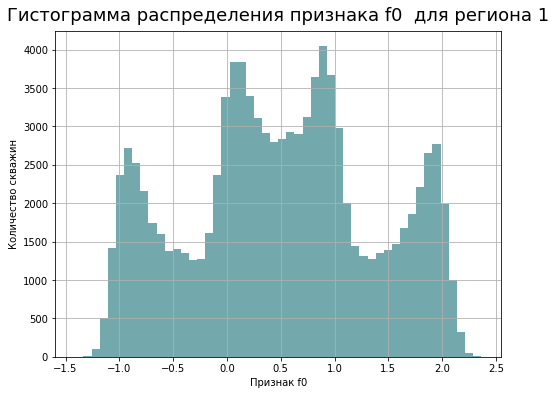

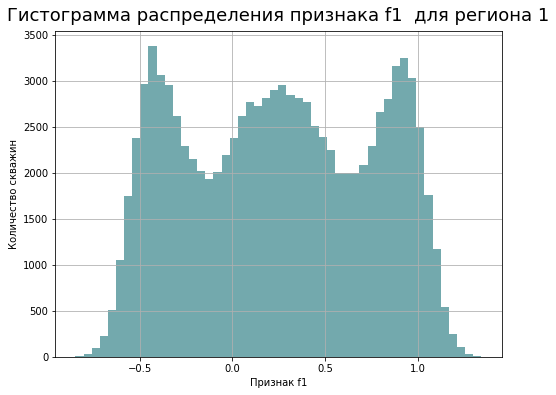

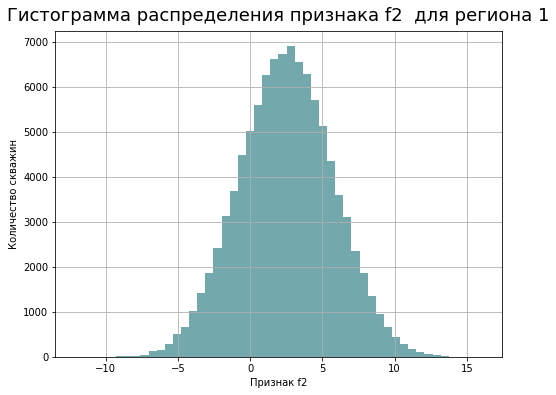

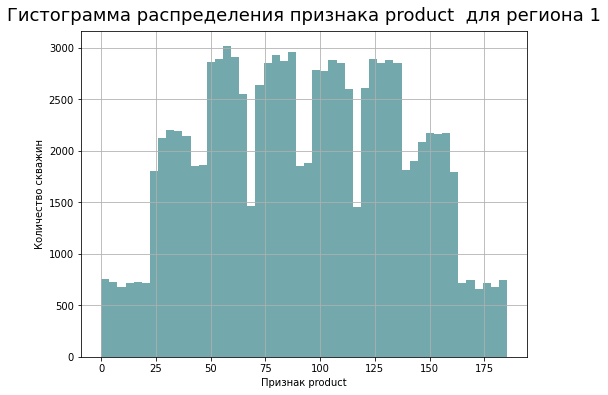

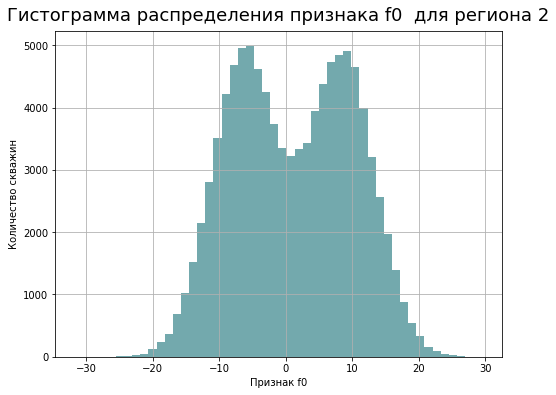

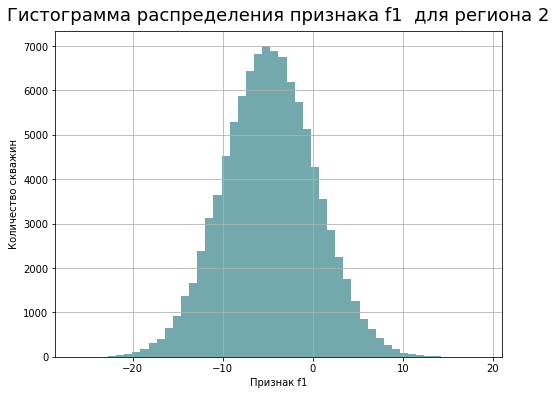

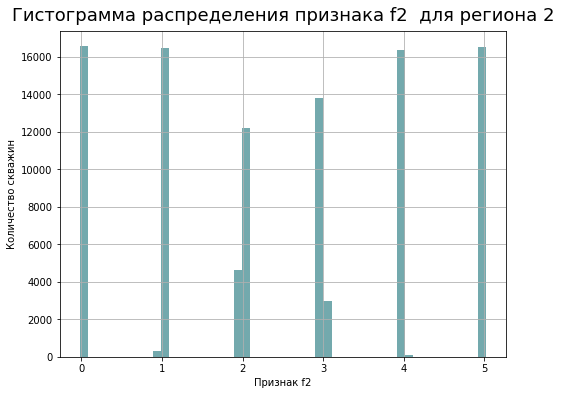

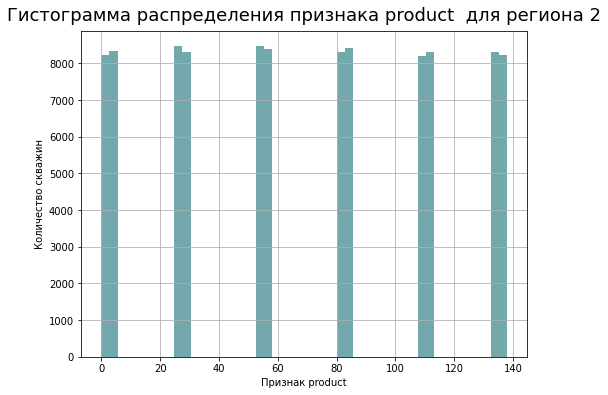

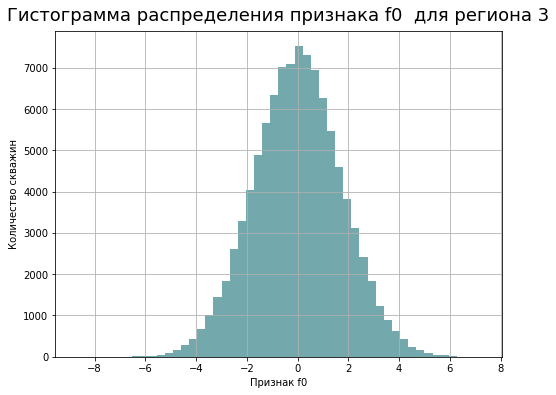

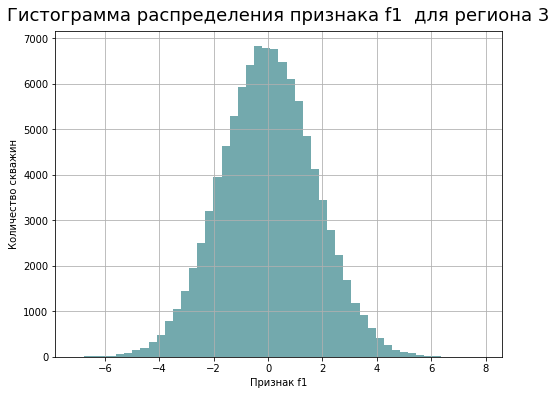

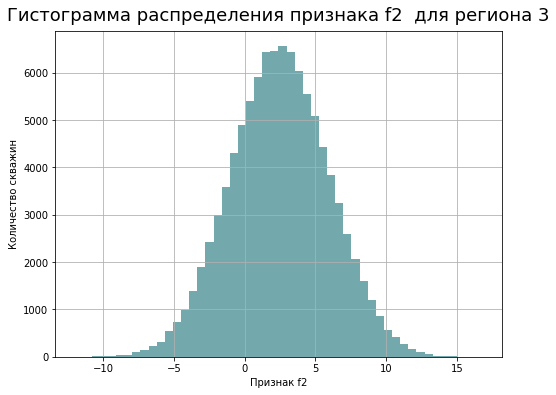

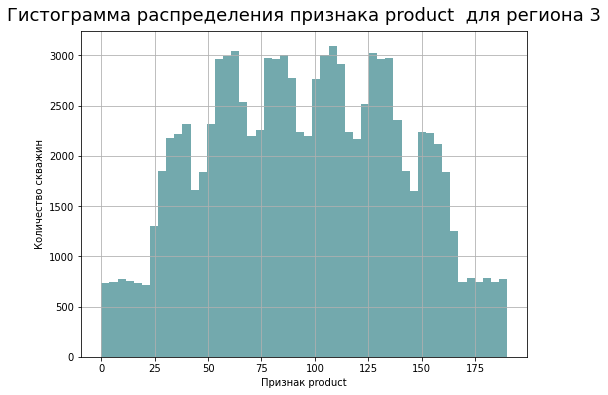

In [17]:
cols = ['f0','f1','f2','product']
i = 1
for data in [data1,data2,data3]:
    for col in cols:
        data[col].hist(bins=50,figsize=(8,6),color='#73A9AD')
        plt.title(f'Гистограмма распределения признака {col}  для региона {i}',pad=10,size=18)
        plt.ylabel('Количество скважин')
        plt.xlabel(f'Признак {col}')
        plt.show()
    i+=1
    

На графиках много интересного! Охарактеризуем каждый регион отдельно

Первый регион:
   * Первый признак распределени полимодальное (есть 4 пика)
   * Второй признак также полимодален (3 моды)
   * Третий признак распредедён нормально
   * Распределение целевого признака достаточно сложное
   
    Первичные выводы: Модели линейной регрессии, возможно, будет непросто улавливать связь между признакми, распределёнными таким образом, далее посмотрим на матрицу корреляций
    
Второй регион:
   * Первый признак распределён бимодально
   * Второй признак распределён нормально
   * Третий признак распределён дискретно 
   * Распределение целевого признака также дискретно (принимает всего 12 уникальных значений)
   
Третий регион:

  * Все признакми распределены нормально
  * Целевой признак распределён бимодально

Выбросов в данных нет, множество данных имеет сложное распределение, отличное от нормального, стоит посмотреть на матрицу корреляций 
   

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


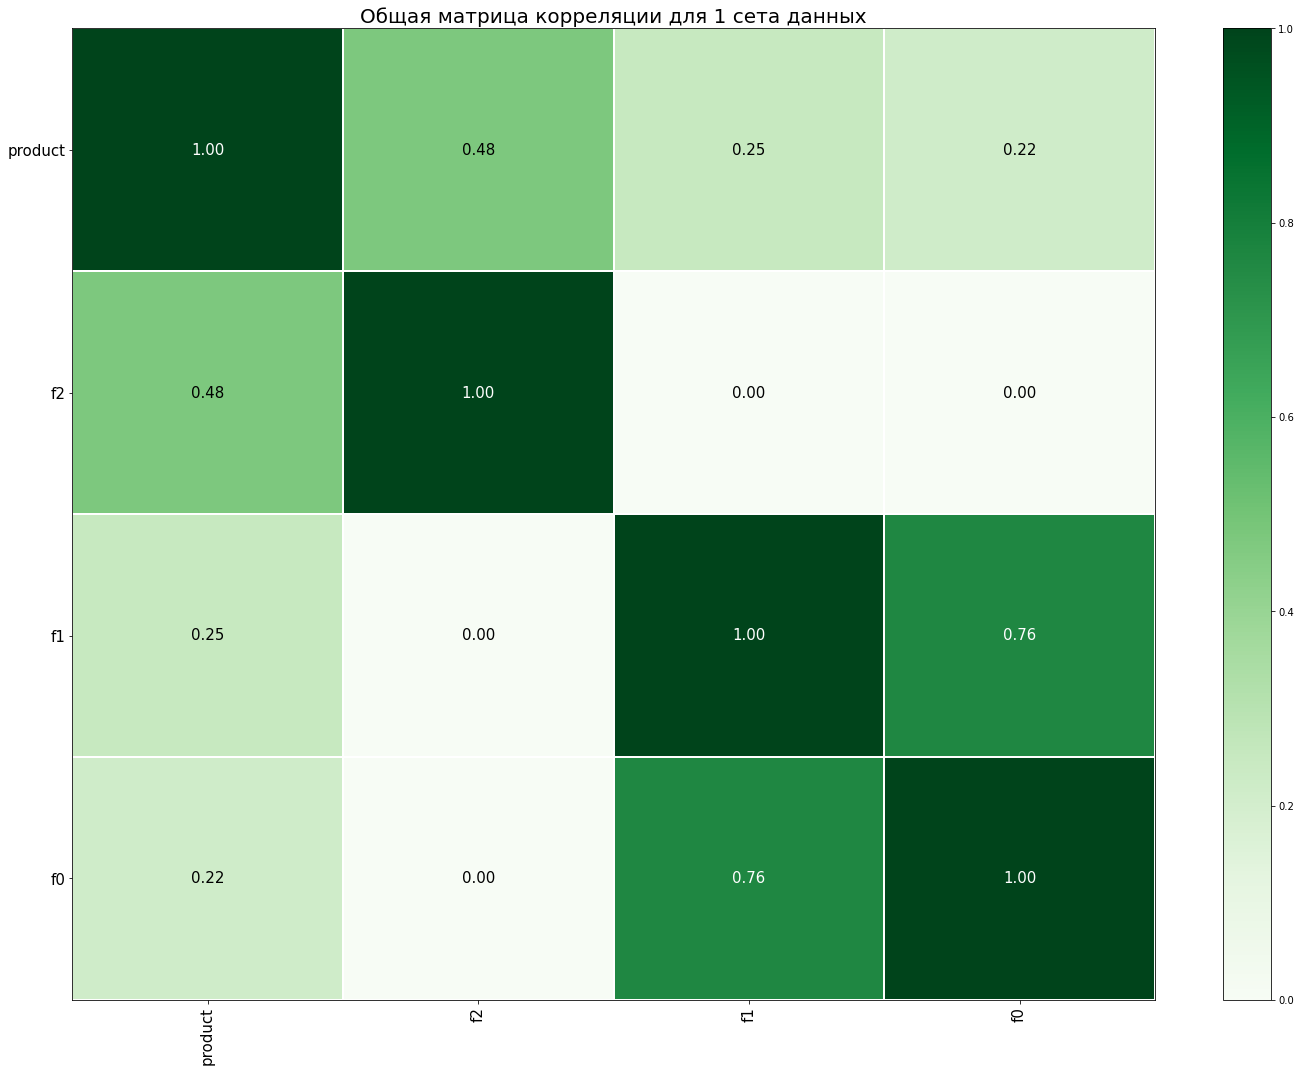

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


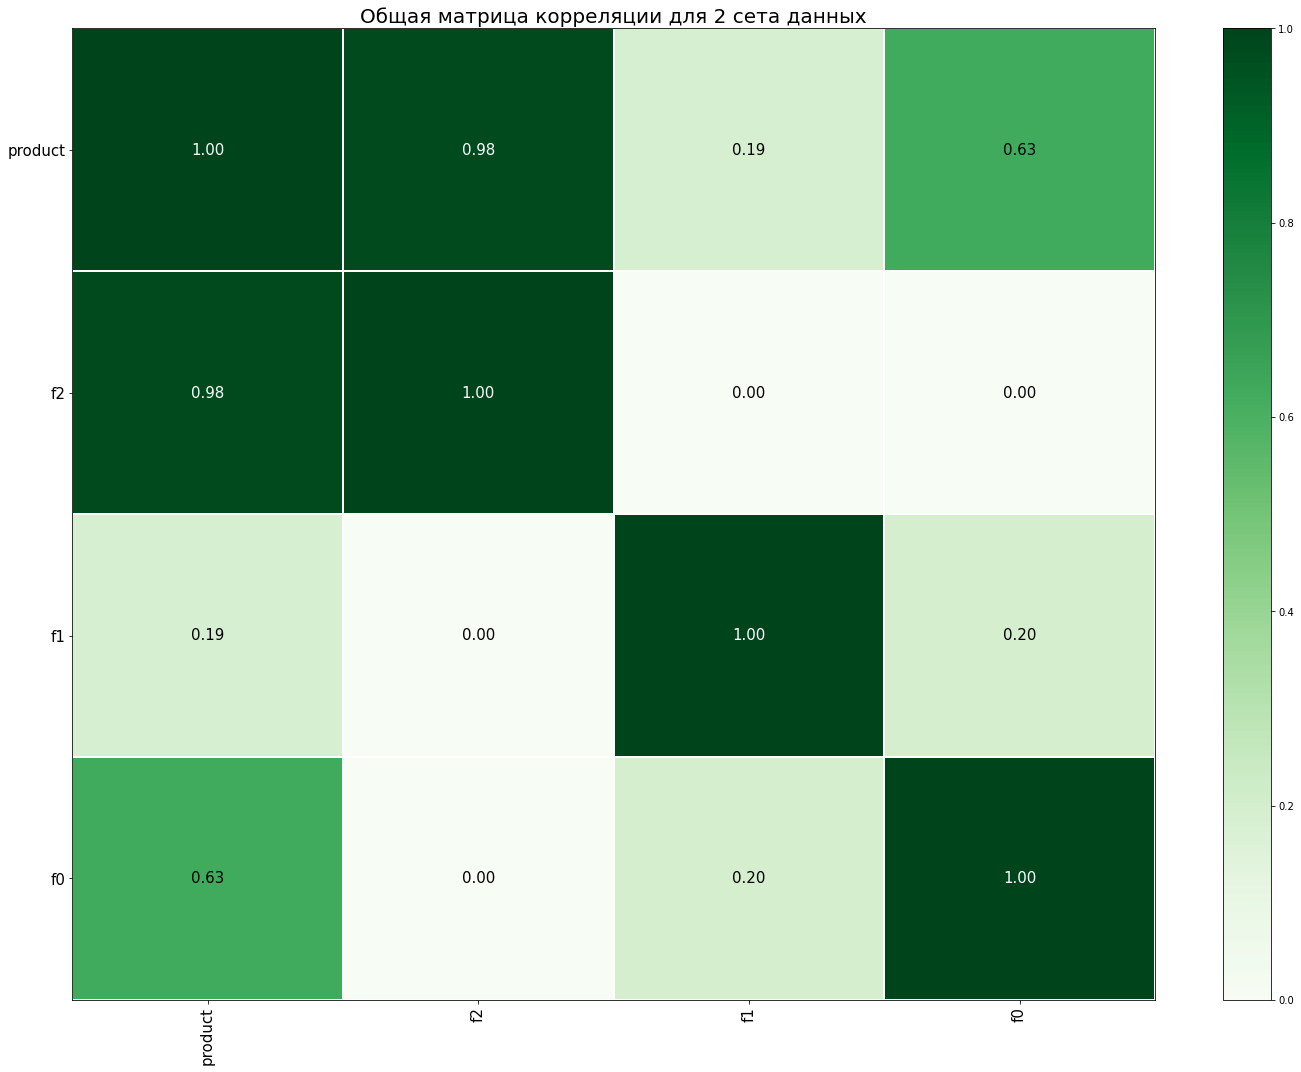

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


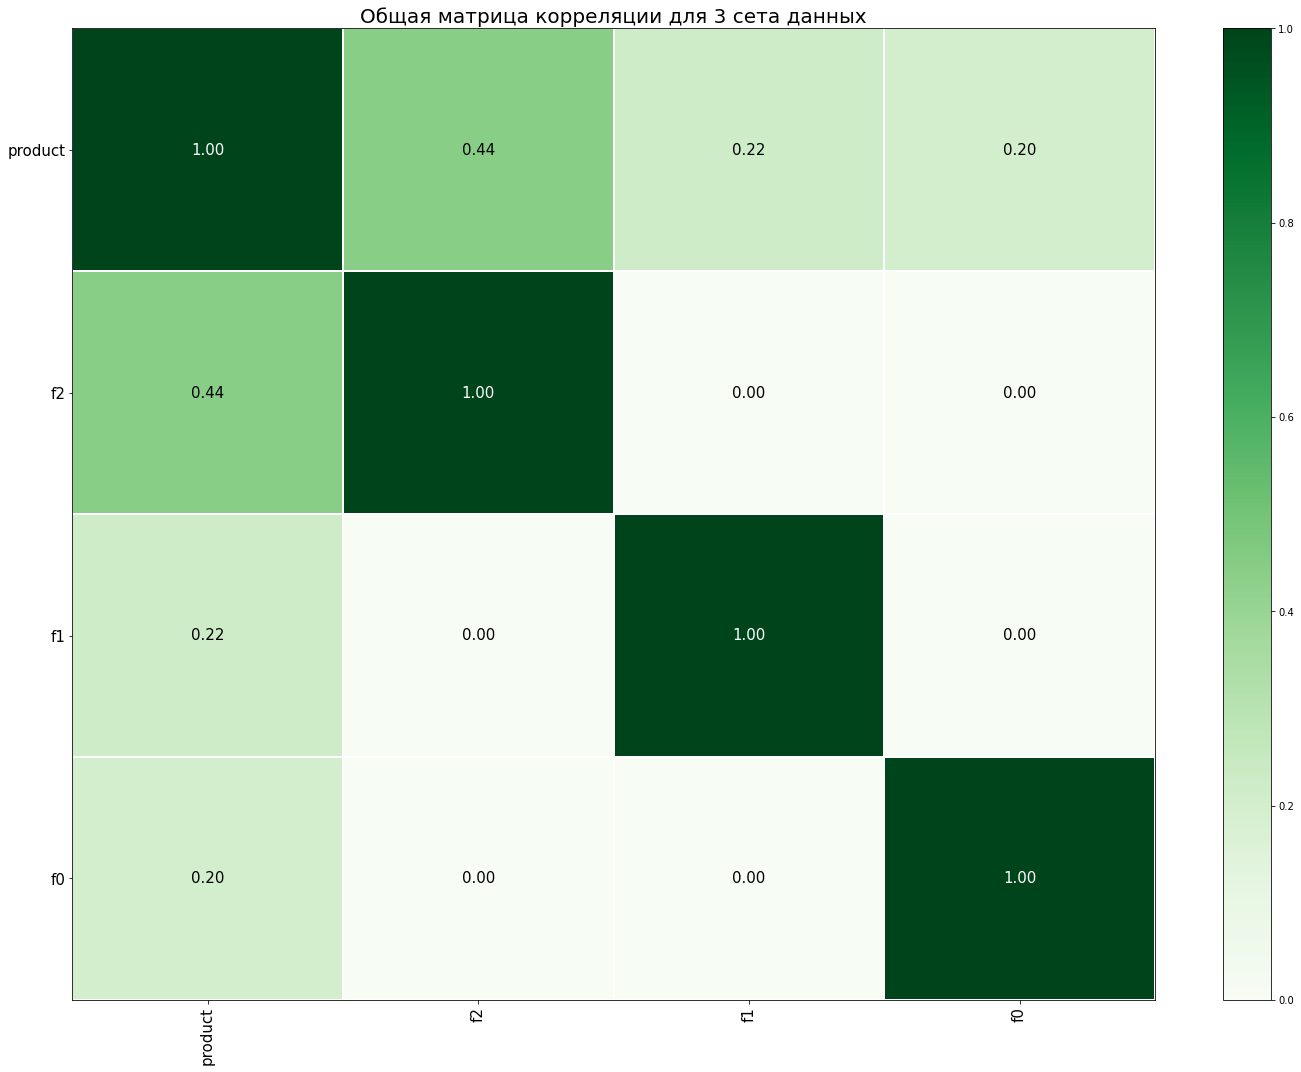

In [18]:
i = 1
for data in [data1,data2,data3]:
    phik_matrix = data.drop('id',axis=1).phik_matrix()
    plot_correlation_matrix(
    phik_matrix.values,
    y_labels=phik_matrix.index,
    x_labels=phik_matrix.columns,
    vmin=0,vmax=1,
    figsize=(20,15),
    fontsize_factor=1.5,
    color_map='Greens'
    )
    plt.title(f'Общая матрица корреляции для {i} сета данных',size=20)
    plt.show()
    i+=1


Первый и третий набор данных похожи по корреляционному анализу, и сильно отличаются от второго набора данных, у которого практически 100% корреляция между целевым и f2 признаком. При этом в первом сете довольно большая корреляция между признаком f1 и f0, в третьем сете данных такой корреляции нет - все это, скорее всего, будет влиять на разную признаковую значимость при обучении модели и в её интерпретируемости.

## Обучение и проверка модели

Обучите и проверьте модель для каждого региона:

 * 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
 
 * 2.2. Обучите модель и сделайте предсказания на валидационной выборке.

 * 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
 
 * 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

Обучение модели будем проводить с помощью пайплайна, используем несколкьо кодировщиков и гиперпараметров при обучении модели линейной регрессии. Всего получится три модели - по одной для каждого региона

In [19]:
data1 = data1.set_index('id')
data2 = data2.set_index('id')
data3 = data3.set_index('id')

In [20]:
data1.head()

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [21]:
cols = ['f0','f1','f2']
data_preprocessor = ColumnTransformer(
    [
        ('num',StandardScaler(),cols)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
[
    ('preprocessor',data_preprocessor),
    ('models',LinearRegression())
])

param_grid = {
    'preprocessor__num':[StandardScaler(),RobustScaler(),MinMaxScaler()]
}

In [22]:
def make_conclusion(data,i):
    print(f'РЕГИОН {i}')
    X_train,X_valid,y_train,y_valid = train_test_split(data.drop('product',axis=1),data['product'],random_state=RANDOM_STATE,
                                                      test_size=0.25)
    grid = GridSearchCV(pipe_final,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error')
    grid.fit(X_train,y_train)
    print(f'Значение коэффициента RMSE для модели линейной регресии при кросс валидации равно',grid.best_score_*(-1))
    print()
    y_pred = grid.best_estimator_.predict(X_valid)
    print('Описательные статистики предсказания')
    print(pd.Series(y_pred).describe())
    print()
    print('Описательные статистики истинных значений')
    print(y_valid.describe())
    print()
    rmse = mean_squared_error(y_valid,y_pred,squared=False)
    print(f'RMSE модели на валидационной выборке равна',rmse)
    print('\n'*5)
    return grid,y_valid,y_pred    #для стат теста, рассчёт арисков и прибыли и построения графиков вернём кортеж из трёх значений
    

In [23]:
grid1, y_valid1, y_pred1 = make_conclusion(data1,1)
grid2, y_valid2, y_pred2 = make_conclusion(data2,2)
grid3, y_valid3, y_pred3 = make_conclusion(data3,3)

РЕГИОН 1
Значение коэффициента RMSE для модели линейной регресии при кросс валидации равно 37.69686738290523

Описательные статистики предсказания
count    24998.000000
mean        92.609840
std         23.048720
min         -9.601984
25%         76.947467
50%         92.602307
75%        108.168283
max        185.493743
dtype: float64

Описательные статистики истинных значений
count    24998.000000
mean        92.388766
std         44.245716
min          0.024830
25%         56.453897
50%         91.522064
75%        128.368812
max        185.344675
Name: product, dtype: float64

RMSE модели на валидационной выборке равна 37.68508926201444






РЕГИОН 2
Значение коэффициента RMSE для модели линейной регресии при кросс валидации равно 0.8896094467301927

Описательные статистики предсказания
count    24999.000000
mean        68.577035
std         45.949710
min         -2.062961
25%         28.572600
50%         57.688601
75%        109.266309
max        139.696959
dtype: float64

Описа

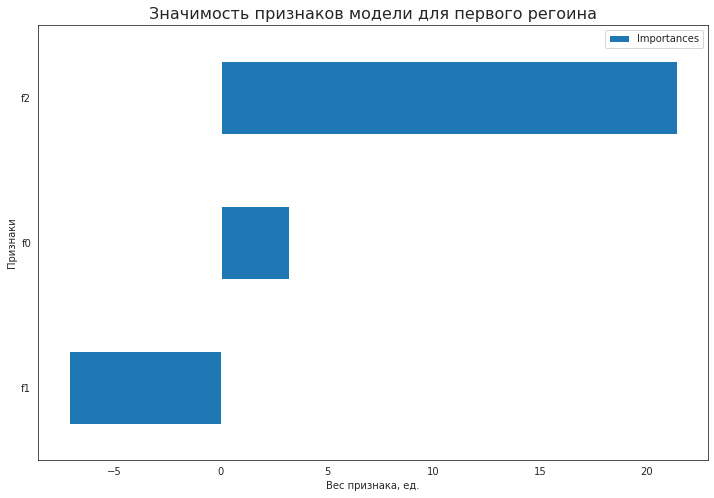

In [24]:
sns.set_style('white')
feature_importances = pd.DataFrame({'Features':['f0','f1','f2'],'Importances':grid1.best_estimator_._final_estimator.coef_})
feature_importances = feature_importances.sort_values(by='Importances',ascending=True)
feature_importances.plot(x='Features',y='Importances',kind='barh',figsize=(12,8))
plt.title('Значимость признаков модели для первого регоина',size=16)
plt.xlabel('Вес признака, ед.')
plt.ylabel('Признаки')
plt.show()

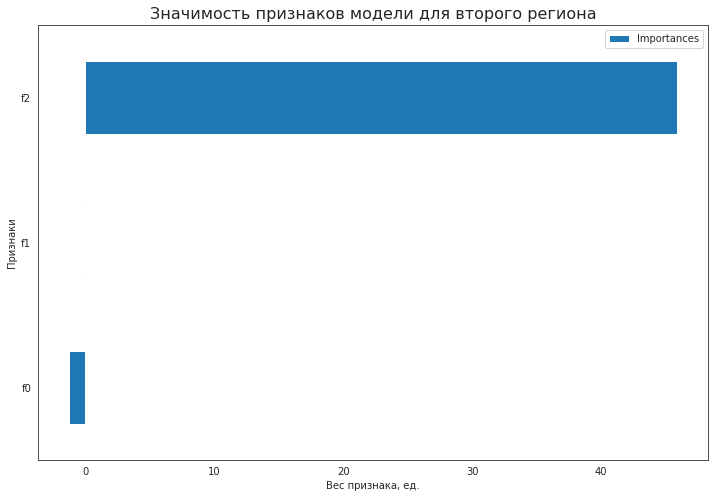

In [25]:
sns.set_style('white')
feature_importances = pd.DataFrame({'Features':['f0','f1','f2'],'Importances':grid2.best_estimator_._final_estimator.coef_})
feature_importances = feature_importances.sort_values(by='Importances',ascending=True)
feature_importances.plot(x='Features',y='Importances',kind='barh',figsize=(12,8))
plt.title('Значимость признаков модели для второго региона',size=16)
plt.xlabel('Вес признака, ед.')
plt.ylabel('Признаки')
plt.show()

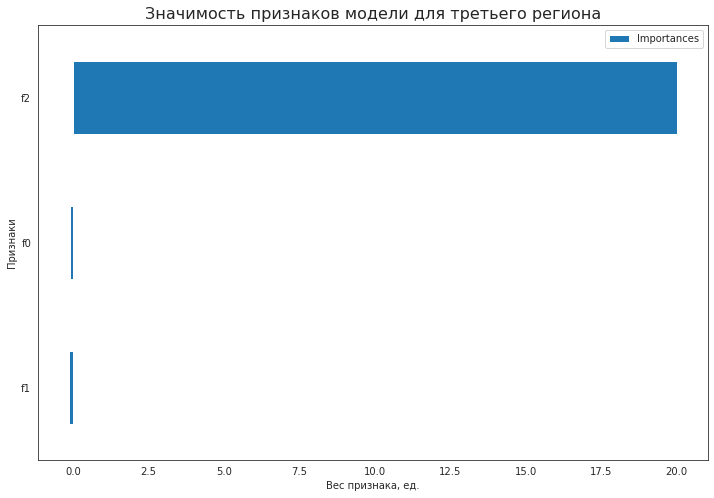

In [26]:
sns.set_style('white')
feature_importances = pd.DataFrame({'Features':['f0','f1','f2'],'Importances':grid3.best_estimator_._final_estimator.coef_})
feature_importances = feature_importances.sort_values(by='Importances',ascending=True)
feature_importances.plot(x='Features',y='Importances',kind='barh',figsize=(12,8))
plt.title('Значимость признаков модели для третьего региона',size=16)
plt.xlabel('Вес признака, ед.')
plt.ylabel('Признаки')
plt.show()

Лучшей моделью линейной регресии оказалась модель второго региона, точность очень высокая, вероятно это связано с очень высокой корреляцией между целевым признаком и признаком f2. Во всех трёх моделях самым значимым оказался именно признак f2, однако корреляция между ним в первом и третьем регионах гораздо ниже, а распределения признаков и целевого не похожи на нормальные, поэтому результаты метрики RMSE очень высокие (модели предсказыаают очень плохо на этих регионах)

Посмотрим на предсказания на валидационной выборке

Ситуация вышла интересная - надёжнее прогнозировать по второму региону, так как RMSE низкая, а точность прогнозов высокая, но вот среднее значение целевого признака гораздо ниже, чем у первого и третьего регионов (68 против 92 и 95 тыс баррелей), соответственно, выручка будет ниже, риск тоже. Проведём два статтета, чтобы убедиться, что средние значения у третьего и первого регона выше, чем у второго. 

Будем проверять гипотезы. Нулевая гипотеза - среднее значение первого и второго регионов одинаковы. Альтернативная - односторонняя гипотеза о том, чтосреднее значение целевого признака первой выборки выше. Введём 10% уровень значимости

In [27]:
alpha = 0.05
result = ttest_ind(y_valid1,y_valid2,alternative='greater')
pvalue = result.pvalue
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу, среднее выборочное значение целевого признака первого региона выше, чем второго')
else:
    print('Нулевая гипотеза не отвергается')

Отвергаем нулевую гипотезу, среднее выборочное значение целевого признака первого региона выше, чем второго


In [28]:
alpha = 0.05
result = ttest_ind(y_valid3,y_valid2,alternative='greater')
pvalue = result.pvalue
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу, среднее выборочное значение целевого признака третьего региона выше, чем второго')
else:
    print('Нулевая гипотеза не отвергается')

Отвергаем нулевую гипотезу, среднее выборочное значение целевого признака третьего региона выше, чем второго


Выводы:

На основе проведённого анализа данных и моделей можно сделать вывод о том, что первый и третий регионы являются более рискованными для предсказания целевого признака, но с более высоким средним. Второй же регион лучше прогнозируется моделью линейной регресси по целевому признаку, но в среднем даёт меньшее значение. Рассчёт прибыли и рисков даст нам лучше понять, каокой регион для наших целей и задач предпочтительнее.

## Подготовка к расчёту прибыли

Прежде, чем заняться рассчётом прибыли, приведу условия задачи и создам глобальные переменные

Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 

In [29]:
enough_quantity = STORE/PRICE
print('Достаточное количество тыс баррелей нефти для безубыточной разработки региона: ',round(enough_quantity,2))

Достаточное количество тыс баррелей нефти для безубыточной разработки региона:  22222.22


In [30]:
print(' Среднее количество с одной скважины для безубыточной разработки региона: ',round(enough_quantity/NUM,2))

 Среднее количество с одной скважины для безубыточной разработки региона:  111.11


Сравним среднее значение запаса в каждом регионе (среднее значение целевого признака каждого региона умнножим на 200 скважин)

In [31]:
for i in range(1,4):
    print(f'Средний запас в {i} регионе на 200 скважин равен {eval(f"y_valid{i}.mean()")*200}')

Средний запас в 1 регионе на 200 скважин равен 18477.753187190923
Средний запас в 2 регионе на 200 скважин равен 13716.723182123284
Средний запас в 3 регионе на 200 скважин равен 19050.927343317686


Выходит, что если брать средние значения по целевому признаку каждого региона, то разработка региона не окупится!

Выводы:

Для того, чтобы разработка региона со скважинами (200 штук) окупилась необходимо найти скважины с максимальным значением целевого признака, если брать среднее значение, то разработка ни одного региона не окупится. Для того, чтобы разработка окупилась нам необходимо не менее 22223 тыс баррелей с 200 скважин. Каждая в среднем должна приносить 112 тыс баррелей

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
* 4.1. Выберите скважины с максимальными значениями предсказаний. 
* 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
* 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [32]:
def revenue(pred_data,true_data,count):
    result = pred_data.sort_values(ascending=False)
    result = result.head(count).index
    result = true_data[result]
    return (result*PRICE).sum()
# Прибыль считаем по фатическому значению, а не предсказаному

Посчитайте риски и прибыль для каждого региона:
* 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
* 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
* 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [33]:
state = np.random.RandomState(12345)
j = 1
for y in zip([y_pred1,y_pred2,y_pred3],[y_valid1,y_valid2,y_valid3]):
    values = []
    for i in range(1000):
            new_data = pd.Series(y[0]).sample(500,random_state=state,replace=True) # 500 точек для разведки
            new_data_result = revenue(new_data,y[1],200)
            values.append(new_data_result)
    values = pd.Series(values)
    print(f'Среднее значение прибыли для {j} региона равно {round(values.mean()/10**9,2)} млрд')
    interval_ = t.interval(alpha=0.95,df=(len(values)-1),loc = values.mean(),scale=values.sem())
    print(f'95% Доверительный интервал {j} региона равен от {round(interval_[0]/10**9,2)} млрд до {round(interval_[1]/10**9,2)} млрд')
    print(f'Риск убытков для {j} региона равен ',((values<10**10).sum()/len(values))*100,'%')
    print()
    j+=1

Среднее значение прибыли для 1 региона равно 10.42 млрд
95% Доверительный интервал 1 региона равен от 10.4 млрд до 10.43 млрд
Риск убытков для 1 региона равен  5.8999999999999995 %

Среднее значение прибыли для 2 региона равно 10.44 млрд
95% Доверительный интервал 2 региона равен от 10.42 млрд до 10.45 млрд
Риск убытков для 2 региона равен  1.9 %

Среднее значение прибыли для 3 региона равно 10.36 млрд
95% Доверительный интервал 3 региона равен от 10.34 млрд до 10.37 млрд
Риск убытков для 3 региона равен  9.8 %



Выводы:

В процессе работы над проектом мной были проделаны следующие шаги:
* Загрузка и предобработка данных
* Далее был проведён исследовательский и корреляционный анализ - регионы различались по распределению признаков, в том числе и целевого. Самая высокая корреляция между признакми и целевой величиной была у второго региона, что впоследствии и сыграло рещающую роль в выборе региона для разработки.
* Далее была проведена подготовка и рассчёт прибыли и рисков для каждого региона с помощью метода Bootstrap

Получились следующие результаты:

Единственным регионом, который устраивает нас по рискам - это второй регион, что логично, у него модель предсказывала данные лучше всего, даже несмотря на  низкую среднюю величину целевого признака. Средняя прибыль для этого региона самая высокая - 10.44 млрд. Третий и первый регионы по среднему значению нас тоже устраивают, но риски слишком большие. Значит, для разработки мы однозначно выбираем второй регион


* Среднее значение прибыли для 2 региона равно 10.44 млрд
* 95% Доверительный интервал 2 региона равен от 10.42 млрд до 10.45 млрд
* Риск убытков для 2 региона равен  1.9 %